# MelSpecVAE v.1
 by Moisés Horta Valenzuela, 2021
> Website: [moiseshorta.audio](https://moiseshorta.audio)

> Twitter: [@hexorcismos](https://twitter.com/hexorcismos)


```
MelSpecVAE is a Variational Autoencoder which synthesizes Mel-Spectrograms thay can be inverted into raw audio waveform.
Currently you can train it with any dataset of .wav audio at 44.1khz Sample Rate and 16bit bitdepth.

> Features:
* Interpolate through 2 different points in the latent space and synthesize the 'in between' sounds.
* Generate short one-shot audio
* Synthesize arbitrarily long audio samples by generating seeds and sampling from the latent space.

> Credits:
* VAE neural network architecture coded following 'The Sound of AI' Youtube tutorial series by Valerio Velardo
* Some utility functions from Marco Passini's MelGAN-VC Jupyter Notebook.

```




In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Run the next cells first for training or generating

In [ ]:
#@title Import Tensorflow and torchaudio 

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5
!pip install git+https://github.com/pvigier/perlin-numpy #for generating perlin and fractal noise

In [ ]:
#@title Import libraries
from glob import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
import soundfile as sf
import time
import IPython
from perlin_numpy import (
    generate_fractal_noise_2d, generate_fractal_noise_3d,
    generate_perlin_noise_2d, generate_perlin_noise_3d
)

In [ ]:
#@title Hyperparameters 
learning_rate = 0.0005 #@param {type:"raw"}
num_epochs_to_train =  40#@param {type:"integer"}
batch_size = 64 #@param {type:"integer"}
vector_dimension = 64 #@param {type:"integer"}

hop=256               #hop size (window size = 4*hop)
sr=44100              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

LEARNING_RATE = learning_rate
BATCH_SIZE = batch_size
EPOCHS = num_epochs_to_train
VECTOR_DIM=vector_dimension

shape=128           #length of time axis of split specrograms         
spec_split=1

In [ ]:
#@title Waveform to Spectrogram conversion

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')

specobj = Spectrogram(n_fft=4*hop, win_length=4*hop, hop_length=hop, pad=0, power=2, normalized=False)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.002):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2500, evaiter=10, tol=1e-8)
  return np.array(np.squeeze(wv))

In [ ]:
#@title Helper functions

#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object)
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*sr):
  x, sr = librosa.load(path,sr=sr)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = spec_split*shape   #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

# Generates timestamp string of "day_month_year_hourMin" 

def  get_time_stamp():
  secondsSinceEpoch = time.time()
  timeObj = time.localtime(secondsSinceEpoch)

  x = ('%d_%d_%d_%d%d' % (timeObj.tm_mday, timeObj.tm_mon, timeObj.tm_year, timeObj.tm_hour, timeObj.tm_min))
  return x


## Training

In [ ]:
#@title Import folder containing .wav files for training
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms

audio_directory = "/content/drive/MyDrive/MelGAN_Datasets/amazondotcom" #@param {type:"string"}

#AUDIO TO CONVERT
awv = audio_array(audio_directory)         #get waveform array from folder containing wav files
aspec = tospec(awv)                        #get spectrogram array
adata = splitcut(aspec)                    #split spectrogams to fixed 
print(np.shape(adata))



In [ ]:
#@title Build VAE Neural Network

#VAE

import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
#tf.disable_v2_behavior()


class VAE:
  """
  VAE represents a Deep Convolutional autoencoder architecture
  with mirrored encoder and decoder components.
  """

  def __init__(self,
               input_shape, #shape of the input data
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.input_shape = input_shape # [28, 28, 1], in this case is 28 x 28 pixels on 1 channel for greyscale
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1,2,3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.reconstruction_loss_weight = 1000000

    self.encoder = None
    self.decoder = None
    self.model = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None
    self._model_input = None

    self._build()

  def summary(self):
    self.encoder.summary()
    print("\n")
    self.decoder.summary()
    print("\n")
    self.model.summary()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

  def compile(self, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    self.model.compile(optimizer=optimizer, loss=self._calculate_combined_loss,
                       metrics=[self._calculate_reconstruction_loss,
                                self._calculate_kl_loss])

  def train(self, x_train, batch_size, num_epochs):
   # checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
   #                              save_best_only=True, mode='auto', period=1)
    self.model.fit(x_train,
                   x_train,
                   batch_size=batch_size,
                   epochs=num_epochs,
                   shuffle=True)
                   #callbacks=[checkpoint])

  def save(self, save_folder="."):
    self._create_folder_if_it_doesnt_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def load_weights(self, weights_path):
    self.model.load_weights(weights_path)

  def reconstruct(self, spec):
      latent_representations = self.encoder.predict(spec)
      reconstructed_spec = self.decoder.predict(latent_representations)
      return reconstructed_spec, latent_representations
  
  def sample_from_latent_space(self, z):
      z_vector = self.decoder.predict(z)
      return z_vector

  @classmethod
  def load(cls, save_folder="."):
      parameters_path = os.path.join(save_folder, "parameters.pkl")
      with open(parameters_path, "rb") as f:
          parameters = pickle.load(f)
      autoencoder = VAE(*parameters)
      weights_path = os.path.join(save_folder, "weights.h5")
      autoencoder.load_weights(weights_path)
      return autoencoder

  def _calculate_combined_loss(self, y_target, y_predicted):
    reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = self._calculate_kl_loss(y_target, y_predicted)
    combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
    return combined_loss
  
  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                           K.exp(self.log_variance), axis =1)
    return kl_loss

  def _create_folder_if_it_doesnt_exist(self, folder):
      if not os.path.exists(folder):
          os.makedirs(folder)

  def _save_parameters(self, save_folder):
      parameters = [
          self.input_shape,
          self.conv_filters,
          self.conv_kernels,
          self.conv_strides,
          self.latent_space_dim
      ]
      save_path = os.path.join(save_folder, "parameters.pkl")
      with open(save_path, "wb") as f:
          pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
      save_path = os.path.join(save_folder, "weights.h5")
      self.model.save_weights(save_path)

#-----------AUTOENCODER----------#

  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name="autoencoder")

#--------------DECODER------------#

  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    """Add conv transpose blocks."""
    # Loop through all the conv layers in reverse order and
    # stop at the first layer
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu_{layer_num}")(x)
    x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_output_layer")(x)
    return output_layer

#----------------ENCODER-----------------#

  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name="encoder")

  def _add_encoder_input(self):
    return Input(shape=self.input_shape, name="encoder_input")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

#-------------Bottleneck (Latent Space)-------------#

  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name="log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., 
                                stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
               name="encoder_output")([self.mu, self.log_variance])
    return x

print("VAE successfully built")

In [ ]:
#@title Training functions

def train(x_train, learning_rate, batch_size, epochs): 
  vae = VAE(
      input_shape = (hop, shape*spec_split, 1),
      conv_filters=(512, 256, 128, 64, 32),
      conv_kernels=(3, 3, 3, 3, 3),
      conv_strides=(2, 2, 2, 2, (2,1)),
      latent_space_dim = VECTOR_DIM
  )
  vae.summary()
  vae.compile(learning_rate)
  vae.train(x_train, batch_size, epochs)
  return vae

def train_tfdata(x_train, learning_rate, epochs=10): 
  vae = VAE(
      input_shape = (hop, 3*shape, 1),
      conv_filters=(512, 256, 128, 64, 32),
      conv_kernels=(3, 3, 3, 3, 3),
      conv_strides=(2, 2, 2, 2, (2,1)),
      latent_space_dim = VECTOR_DIM
  )
  vae.summary()
  vae.compile(learning_rate)
  vae.train(x_train, num_epochs=epochs)
  return vae

def continue_training(checkpoint):
  vae = VAE.load(checkpoint)
  vae.summary()
  vae.compile(LEARNING_RATE)
  vae.train(adata,BATCH_SIZE,EPOCHS)
  return vae

def load_model(checkpoint):
  vae = VAE.load(checkpoint)
  vae.summary()
  vae.compile(LEARNING_RATE)
  return vae


In [ ]:
#@title Start training from scratch or resume training

training_run_name = "Amazondotcom_e360" #@param {type:"string"}
checkpoint_save_directory = "/content/drive/MyDrive/MelSpecVAE/" #@param {type:"string"}
resume_training = True #@param {type:"boolean"}
resume_training_checkpoint_path = "/content/drive/MyDrive/MelSpecVAE/Amazondotcom_e320_22_4_2021_1417_h256_w128_z64" #@param {type:"string"}

current_time = get_time_stamp()

if not resume_training:
  vae = train(adata, LEARNING_RATE, BATCH_SIZE, EPOCHS)
 #vae = train_tfdata(dsa, LEARNING_RATE, EPOCHS)
  vae.save(f"{checkpoint_save_directory}{training_run_name}_{current_time}_h{hop}_w{shape}_z{VECTOR_DIM}")
else:
  vae = continue_training(resume_training_checkpoint_path)
  vae.save(f"{checkpoint_save_directory}{training_run_name}_{current_time}_h{hop}_w{shape}_z{VECTOR_DIM}")


## Generation

In [ ]:
#@title Build VAE Neural Network

#VAE

import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


class VAE:
  """
  VAE represents a Deep Convolutional autoencoder architecture
  with mirrored encoder and decoder components.
  """

  def __init__(self,
               input_shape, #shape of the input data
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.input_shape = input_shape # [28, 28, 1], in this case is 28 x 28 pixels on 1 channel for greyscale
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1,2,3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.reconstruction_loss_weight = 1000000

    self.encoder = None
    self.decoder = None
    self.model = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None
    self._model_input = None

    self._build()

  def summary(self):
    self.encoder.summary()
    print("\n")
    self.decoder.summary()
    print("\n")
    self.model.summary()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

  def compile(self, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    self.model.compile(optimizer=optimizer, loss=self._calculate_combined_loss,
                       metrics=[self._calculate_reconstruction_loss,
                                self._calculate_kl_loss])

  def train(self, x_train, batch_size, num_epochs):
   # checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
   #                              save_best_only=True, mode='auto', period=1)
    self.model.fit(x_train,
                   x_train,
                   batch_size=batch_size,
                   epochs=num_epochs,
                   shuffle=True)
                   #callbacks=[checkpoint])

  def save(self, save_folder="."):
    self._create_folder_if_it_doesnt_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def load_weights(self, weights_path):
    self.model.load_weights(weights_path)

  def reconstruct(self, spec):
      latent_representations = self.encoder.predict(spec)
      reconstructed_spec = self.decoder.predict(latent_representations)
      return reconstructed_spec, latent_representations
  
  def sample_from_latent_space(self, z):
      z_vector = self.decoder.predict(z)
      return z_vector

  @classmethod
  def load(cls, save_folder="."):
      parameters_path = os.path.join(save_folder, "parameters.pkl")
      with open(parameters_path, "rb") as f:
          parameters = pickle.load(f)
      autoencoder = VAE(*parameters)
      weights_path = os.path.join(save_folder, "weights.h5")
      autoencoder.load_weights(weights_path)
      return autoencoder

  def _calculate_combined_loss(self, y_target, y_predicted):
    reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = self._calculate_kl_loss(y_target, y_predicted)
    combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
    return combined_loss
  
  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                           K.exp(self.log_variance), axis =1)
    return kl_loss

  def _create_folder_if_it_doesnt_exist(self, folder):
      if not os.path.exists(folder):
          os.makedirs(folder)

  def _save_parameters(self, save_folder):
      parameters = [
          self.input_shape,
          self.conv_filters,
          self.conv_kernels,
          self.conv_strides,
          self.latent_space_dim
      ]
      save_path = os.path.join(save_folder, "parameters.pkl")
      with open(save_path, "wb") as f:
          pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
      save_path = os.path.join(save_folder, "weights.h5")
      self.model.save_weights(save_path)

#-----------AUTOENCODER----------#

  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name="autoencoder")

#--------------DECODER------------#

  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    """Add conv transpose blocks."""
    # Loop through all the conv layers in reverse order and
    # stop at the first layer
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu_{layer_num}")(x)
    x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_output_layer")(x)
    return output_layer

#----------------ENCODER-----------------#

  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name="encoder")

  def _add_encoder_input(self):
    return Input(shape=self.input_shape, name="encoder_input")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

#-------------Bottleneck (Latent Space)-------------#

  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name="log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., 
                                stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
               name="encoder_output")([self.mu, self.log_variance])
    return x

print("VAE successfully built")

In [ ]:
#@title Load Checkpoint for Generating

checkpoint_load_directory = "/content/drive/MyDrive/MelSpecVAE/Amazondotcom_e360_22_4_2021_151_h256_w128_z64" #@param {type:"string"}

#-------LOAD MODEL FOR GENERATING-------------#

vae = VAE.load(checkpoint_load_directory)
#load_model('/content/drive/MyDrive/SpecVAE/Pkl/Gabor19042021_h256_w128_z642')
print("Loaded checkpoint")

In [ ]:
#@title Import synthesis utility functions

#-----TESTING FUNCTIONS ----------- #

def select_spec(spec, labels, num_spec=10):
    sample_spec_index = np.random.choice(range(len(spec)), num_spec)
    sample_spec = spec[sample_spec_index]
    sample_labels = labels[sample_spec_index]
    return sample_spec, sample_labels


def plot_reconstructed_spec(spec, reconstructed_spec):
    fig = plt.figure(figsize=(15, 3))
    num_spec = len(spec)
    for i, (image, reconstructed_image) in enumerate(zip(spec, reconstructed_spec)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_spec, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_spec, i + num_spec + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()


def plot_spec_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

#---------------NOISE GENERATOR FUNCTIONS ------------#

def generate_random_z_vect(seed=1001,size_z=1,scale=1.0):
    np.random.seed(seed)
    x = np.random.uniform(low=(scale * -1.0), high=scale, size=(size_z,VECTOR_DIM))
    return x

def generate_z_vect_from_perlin_noise(seed=1001, size_z=1, scale=1.0):
    np.random.seed(seed)
    x = generate_perlin_noise_2d((size_z, VECTOR_DIM), (1,1))
    x = x*scale
    return x

def generate_z_vect_from_fractal_noise(seed=1001, size_z=1, scale=1.0,):
    np.random.seed(seed)
    x = generate_fractal_noise_2d((size_z, VECTOR_DIM), (1,1),)
    x = x*scale
    return x


#-------SPECTROGRAM AND SOUND SYNTHESIS UTILITY FUNCTIONS -------- #

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave_reconstruct(spec, spec1, name, path='../content/', show=False, save=False):
  specarr = chopspec(spec)
  specarr1 = chopspec(spec1)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = specarr1
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec1)
  awv = deprep(a)
  abwv = deprep(ab)
  if save:
    print('Saving...')
    pathfin = f'{path}/{name}'
    sf.write(f'{pathfin}.wav', awv, sr)
    print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Reconstructed')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Input')
    plt.show()
  return abwv

#Converting from Z vector generated spectrogram to waveform
def towave_from_z(spec, name, path='../content/', show=False, save=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  print('Assembling and Converting...')
  a = specass(a,spec)
  awv = deprep(a)
  if save:
    print('Saving...')
    pathfin = f'{path}/{name}'
    sf.write(f'{pathfin}.wav', awv, sr)
    print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=1)
    axs.imshow(np.flip(a, -2), cmap=None)
    axs.axis('off')
    axs.set_title('Decoder Synthesis')
    plt.show()
  return awv


In [ ]:
#@title Compare resynthesized MelSpec with ground truth MelSpec

num_spec_to_resynthesize =  5 #@param {type:"integer"}

num_sample_spec_to_show = num_spec_to_resynthesize
sample_spec, _ = select_spec(adata, adata, num_sample_spec_to_show)
reconstructed_spec, _ = vae.reconstruct(sample_spec)
plot_reconstructed_spec(sample_spec, reconstructed_spec)

reconst = num_sample_spec_to_show

for i in range(reconst):
  y = towave_reconstruct(reconstructed_spec[i],sample_spec[i],name='reconstructions',show=True, save=False)


  4%|▍         | 100/2500 [00:00<00:03, 615.24it/s, loss=0.154, spectral_convergence=-7.86]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:03<00:00, 626.30it/s, loss=0.138, spectral_convergence=-8.35]


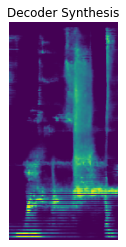

  4%|▍         | 100/2500 [00:00<00:03, 608.05it/s, loss=0.0973, spectral_convergence=-12.2]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 592.60it/s, loss=0.0741, spectral_convergence=-14.1]


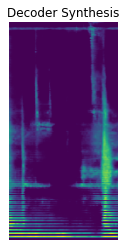

  4%|▍         | 100/2500 [00:00<00:04, 569.94it/s, loss=0.558, spectral_convergence=-6.75]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 560.14it/s, loss=0.416, spectral_convergence=-8.08]


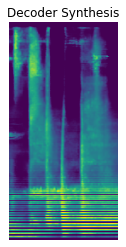

  4%|▍         | 100/2500 [00:00<00:04, 550.96it/s, loss=0.204, spectral_convergence=-10.7]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 567.50it/s, loss=0.161, spectral_convergence=-12.4]


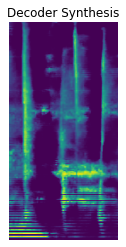

  4%|▍         | 100/2500 [00:00<00:04, 549.49it/s, loss=0.414, spectral_convergence=-8.19]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 553.94it/s, loss=0.306, spectral_convergence=-10.2]


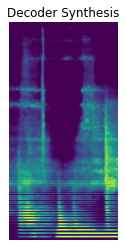

  4%|▎         | 90/2500 [00:00<00:04, 583.77it/s, loss=0.159, spectral_convergence=-10.5]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 548.93it/s, loss=0.134, spectral_convergence=-11.8]


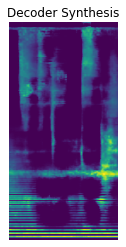

  4%|▎         | 90/2500 [00:00<00:04, 484.80it/s, loss=0.317, spectral_convergence=-8.04]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 533.23it/s, loss=0.234, spectral_convergence=-9.85]


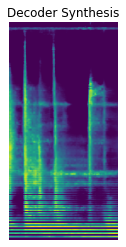

  4%|▎         | 90/2500 [00:00<00:05, 476.10it/s, loss=0.451, spectral_convergence=-7.78]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 524.61it/s, loss=0.323, spectral_convergence=-9.95]


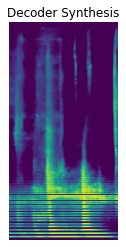

  4%|▎         | 90/2500 [00:00<00:04, 531.53it/s, loss=1.47, spectral_convergence=-6.21]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 533.63it/s, loss=0.909, spectral_convergence=-9]


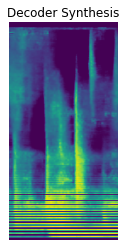

  4%|▎         | 90/2500 [00:00<00:04, 535.52it/s, loss=0.703, spectral_convergence=-6.77]

(2, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 514.19it/s, loss=0.488, spectral_convergence=-8.26]


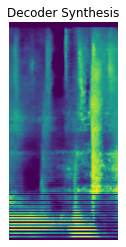

Generated from seed: 754931874


In [ ]:
#@title Generate one-shot samples from latent space with random or manual seed
num_samples_to_generate =   10#@param {type:"integer"}
use_seed = True #@param {type:"boolean"}
seed =  754931874 #@param {type:"slider", min:0, max:4294967295, step:1}
scale_z_vectors =  -2.2 #@param {type:"slider", min:-5.0, max:5.0, step:0.1}
save_audio = False #@param {type:"boolean"}
audio_name = "one_shot" #@param {type:"string"}
audio_save_directory = "/content/" #@param {type:"string"}

y = np.random.randint(0, 2**32-1)                          # generated random int to pass and convert into vector
i=0
while i < num_samples_to_generate:
  if not use_seed:
    z = generate_random_z_vect(y, num_samples_to_generate,scale=scale_z_vectors)  
  else:
    z = generate_random_z_vect(seed, num_samples_to_generate,scale=scale_z_vectors)
  z_sample = np.array(vae.sample_from_latent_space(z))
  towave_from_z(z_sample[i], name=f'{audio_name}_{i}',path=audio_save_directory,show=True, save=save_audio)
  i+=1

if not use_seed:
  print("Generated from seed:", y)
else:
  print("Generated from seed:", seed)

  1%|          | 30/2500 [00:00<00:08, 285.77it/s, loss=1.52, spectral_convergence=-2.72]

(33, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:08<00:00, 295.51it/s, loss=0.506, spectral_convergence=-9.12]


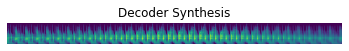

Generated from seed: 816861568


In [ ]:
#@title Generate arbitrary long audio from latent space with random or custom seed using uniform, Perlin or fractal noise
num_seeds_to_generate = 32#@param {type:"integer"}
noise_type = "fractal" #@param ["uniform", "perlin", "fractal"]
use_seed = True #@param {type:"boolean"}
seed =  816861568 #@param {type:"slider", min:0, max:4294967295, step:1}
scale_z_vectors =  3.2 #@param {type:"slider", min:-5.0, max:5.0, step:0.1}
save_audio = False #@param {type:"boolean"}
audio_name = "VAE_synthesis2" #@param {type:"string"}
audio_save_directory = "/content" #@param {type:"string"}


y = np.random.randint(0, 2**32-1)                         # generated random int to pass and convert into vector
if not use_seed:
  if noise_type == "uniform":
    z = generate_random_z_vect(y, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
  if noise_type == "perlin":
    z = generate_z_vect_from_perlin_noise(y, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
  if noise_type == "fractal":
    z = generate_z_vect_from_fractal_noise(y, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
if use_seed:
  if noise_type == "uniform":
    z = generate_random_z_vect(seed, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
  if noise_type == "perlin":
    z = generate_z_vect_from_perlin_noise(seed, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
  if noise_type == "fractal":
    z = generate_z_vect_from_fractal_noise(seed, num_seeds_to_generate,scale_z_vectors)            # vectors to input into latent space
z_sample = np.array(vae.sample_from_latent_space(z))
assembled_spec = testass(z_sample)
towave_from_z(assembled_spec,audio_name,audio_save_directory,show=True,save=save_audio)

if not use_seed:
  print("Generated from seed:", y)
else:
  print("Generated from seed:", seed)

  4%|▍         | 110/2500 [00:00<00:03, 649.78it/s, loss=4.06, spectral_convergence=-5.49]

(6, 256, 128, 1)
Generating...
Assembling and Converting...


100%|██████████| 2500/2500 [00:04<00:00, 616.86it/s, loss=2.21, spectral_convergence=-8.42]


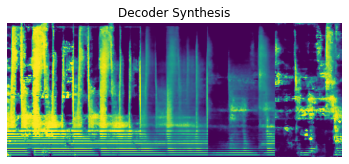

Generated from seed: 1065436168


In [ ]:
#@title Interpolate between two seeds for n-amount of steps
#num_seeds_to_generate =  3 #@param {type:"integer"}
use_seed = False #@param {type:"boolean"}
seed =  2580802177 #@param {type:"slider", min:0, max:4294967295, step:1}
num_interpolation_steps =   5#@param {type:"integer"}
scale_z_vectors =  -1.7 #@param {type:"slider", min:-5.0, max:5.0, step:0.1}
scale_interpolation_ratio =  1.2 #@param {type:"slider", min:-5.0, max:5.0, step:0.1}
save_audio = False #@param {type:"boolean"}
audio_name = "random_seed_scale_2.5" #@param {type:"string"}
audio_save_directory = "/content/drive/MyDrive/MelSpecVAE/Amazondotcom_e160_21_4_2021_2156_h256_w128_z64/Audio/" #@param {type:"string"}

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2,scale, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(-scale, scale, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)
 
y = np.random.randint(0, 2**32-1)
if not use_seed:
  pts = generate_random_z_vect(y,num_seeds_to_generate,scale_z_vectors)
else:
  pts = generate_random_z_vect(seed,num_seeds_to_generate,scale_z_vectors)

# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1], scale_interpolation_ratio, num_interpolation_steps)
#print(np.shape(interpolated))
interp = np.array(vae.sample_from_latent_space(interpolated))
assembled_spec = testass(interp)
towave_from_z(assembled_spec,audio_name,audio_save_directory,show=True, save=save_audio)
#print(np.shape(assembled_spec))

if not use_seed:
  print("Generated from seed:", y)
else:
  print("Generated from seed:", seed)

In [ ]:

SEEDS = [1001,244,1014,13205, 1209,103924,1209,102980345,3049]

i = int(0)
while i <= 10:
  y = np.random.randint(0, 20000)
  z = generate_random_z_vect(y, 10,0.0,scale=2.0)
  z_sample = np.array(autoencoder.sample_from_latent_space(z))
  towave_from_z(z_sample[i],name="test",show=True, save=False)
  i+=1